In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

In [2]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.


In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 7.7+ MB


In [4]:
Y = weather_df["temperature"]
X = weather_df[["humidity","windspeed","windbearing","pressure"]]

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528512


Assumption 1 is already met (forced linear coefficients instead of any other type).

Now, check assumption 2: the error term should be zero (on average).

In [5]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the temperature model is: {}".format(np.mean(errors)))

Mean of the errors in the temperature model is: -6.185691729267529e-15


So far so good! The average error is essentially zero. Check for homoscedasicity next.

In [6]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


No good...the error appears to be heteroscedastic. Let's plot the errors and see what can be visualized.

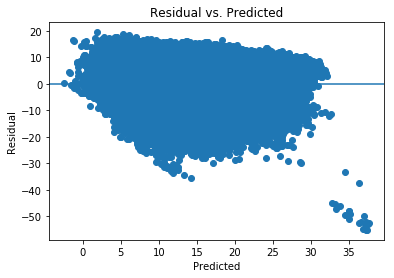

In [7]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

There are some clear outliers (bottom right corner of above plot) where the error grows with the target variable.

Checking assumption 4: low multicollinearity

In [8]:
weather_df.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
temperature,1.000,0.993,-0.632,0.009,0.030,0.393,nan,-0.005
apparenttemperature,0.993,1.000,-0.603,-0.057,0.029,0.382,nan,-0.000
humidity,-0.632,-0.603,1.000,-0.225,0.001,-0.369,nan,0.005
windspeed,0.009,-0.057,-0.225,1.000,0.104,0.101,nan,-0.049
windbearing,0.030,0.029,0.001,0.104,1.000,0.048,nan,-0.012
visibility,0.393,0.382,-0.369,0.101,0.048,1.000,nan,0.060
loudcover,nan,nan,nan,nan,nan,nan,nan,nan
pressure,-0.005,-0.000,0.005,-0.049,-0.012,0.060,nan,1.000


There is little to no correlation between the 4 independent variables, so that's good!

Last check on assumption 5: error terms should be uncorrelated.

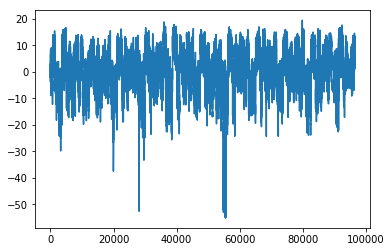

In [9]:
plt.plot(errors)
plt.show()

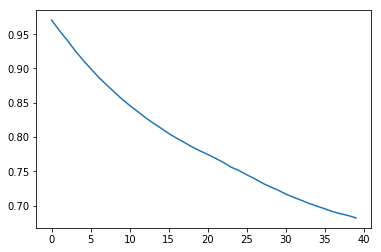

In [10]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The errors are highly correlated to themselves, which is an issue for the validity of this model.